In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import json

from Modules.Feature_Extraction_temporal_domain import *

In [3]:
import warnings

warnings.filterwarnings("ignore")

## Read Preprocessed Data

In [4]:
def read_csv(filepath):
    f = open(filepath)
    data = json.load(f)
    return data

ecg = read_csv('Preprocessed_data/ecg/ecg_unfiltered.txt')
ecg_filt = read_csv('Preprocessed_data/ecg/ecg_filtered.txt')

### Crop segments of the signals to remove a few minutes from the start and end
At the very beginning or the end, the device is being attached? removed from the patient hence leading to a high variance in signals

In [6]:
#remove first and last few minutes
for patient in ecg_filt:
    ecg_filt[patient] = ecg_filt[patient][5000:700000]
    ecg[patient] = ecg[patient][5000:700000]

### Divide signals from patients into chunks of 10 seconds

In [7]:
duration = int(20*62.4725)
segments_ecg = []

for patient in ecg_filt:
    values = ecg_filt[patient]
    for i in range(0,len(values) - duration + 1, duration):
        segments_ecg.append(values[i : (i + duration)])

## Clustering using DBSCAN

In [23]:
def find_anomalies_using_DBSCAN(segment, num):
    ecg, info = nk.ecg_process(segment, sampling_rate=62.475)
    events  = list(range(1,int(20*62.4725),125))
    epochs = nk.epochs_create(ecg, events=events,epochs_start=-0.1, epochs_end=1.9)
    features = nk.ecg_eventrelated(epochs)
    features_only = features.fillna(0).drop(columns=["Label", "Event_Onset"])
    clustering = DBSCAN(eps=80, min_samples=3).fit(features_only)
    DBSCAN_dataset = features_only.copy()
    DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_

    clusters = DBSCAN_dataset.Cluster.value_counts().to_frame()
    y_pred = clustering.fit_predict(features_only)

    anomoly_indices = np.where(y_pred == -1)[0]

    anomolous_signals = np.take(features, anomoly_indices, 0)


    fig, ax = plt.subplots()

    ax.set_title("Anomolous signals")
    ax.set_xlabel("Time (seconds)")
    t = np.arange(0,int(20*62.4725))

    ax.plot(t,segment, color = "blue")
    if len(anomoly_indices) >=3:
        for i in range(len(anomolous_signals)):
            start = anomolous_signals["Event_Onset"][i]
            ax.plot(t[start:start+62],segment[start:start+62], color = "red")
            #plt.savefig('anomalies_clustering/'+str(num)+'.png')

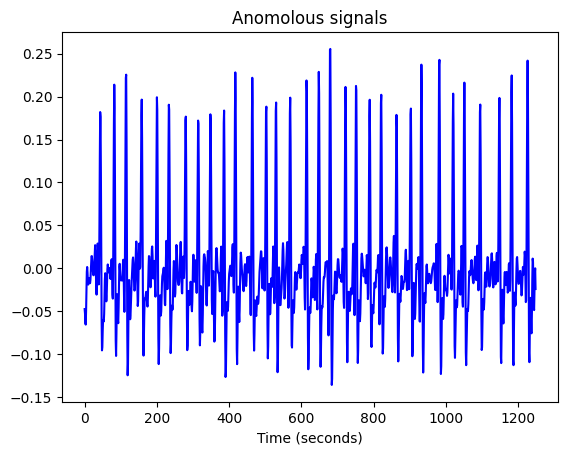

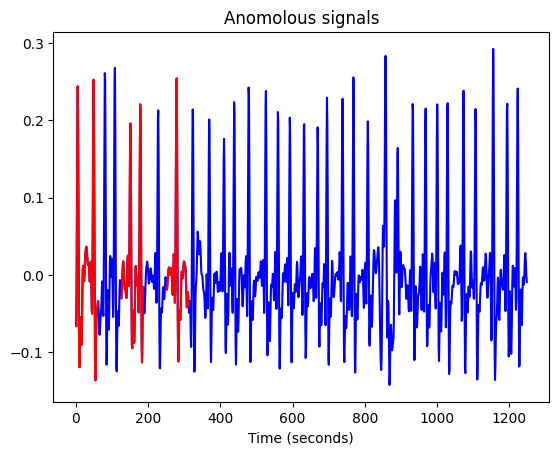

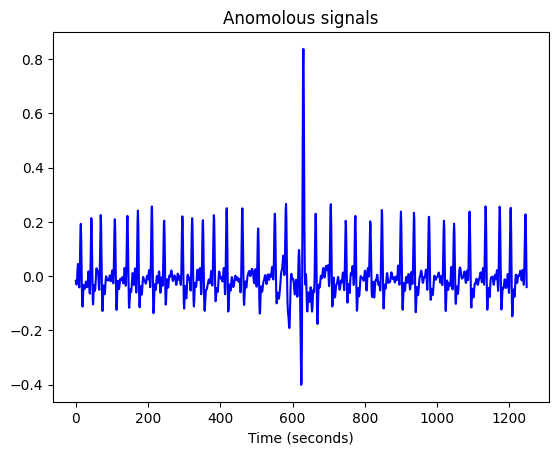

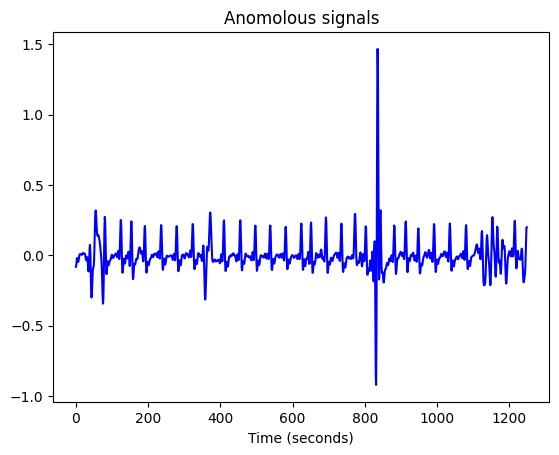

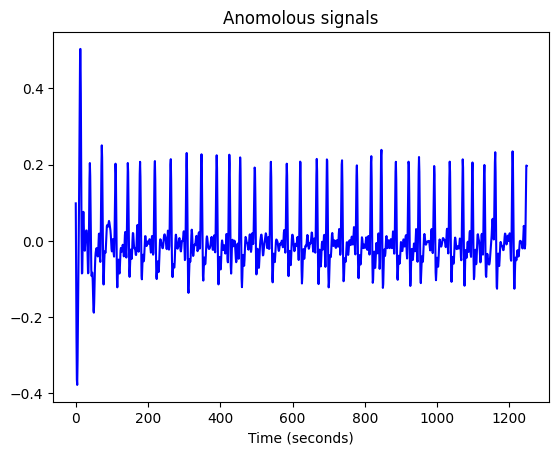

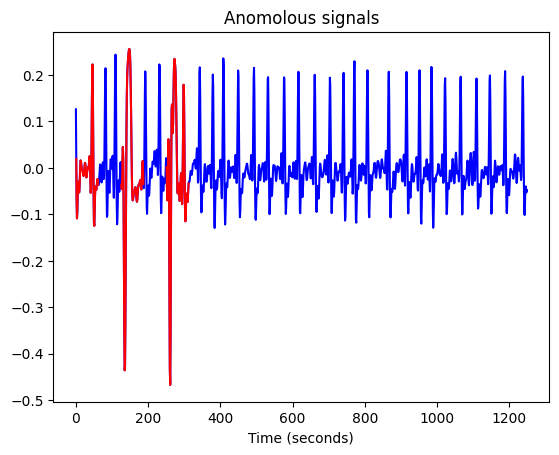

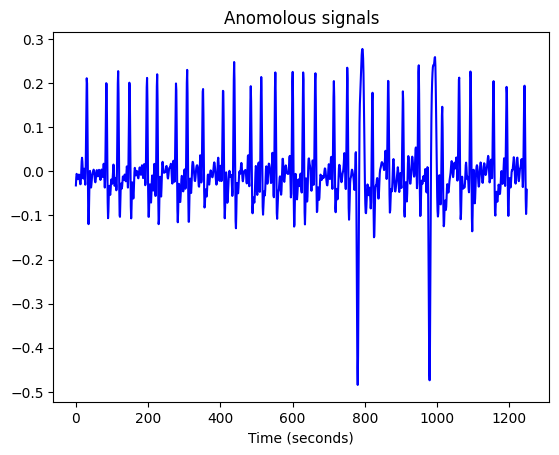

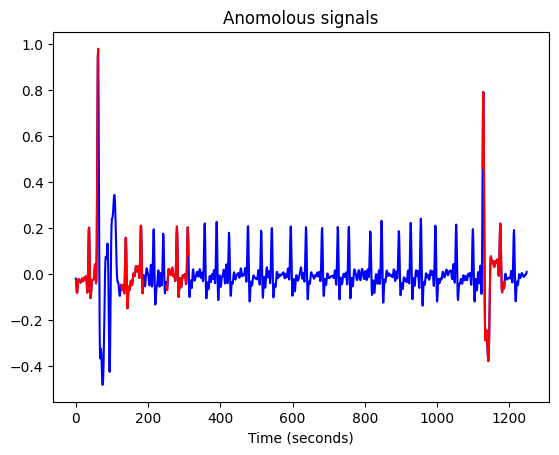

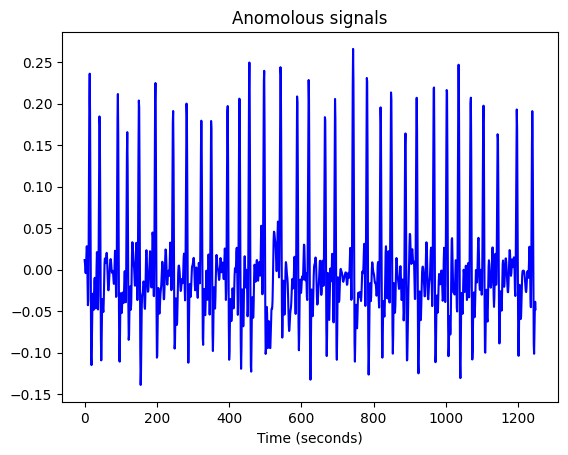

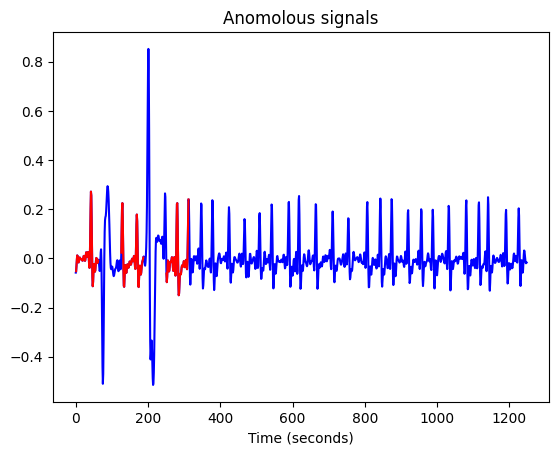

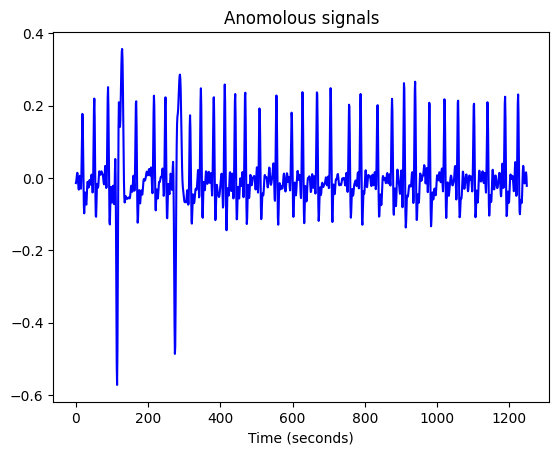

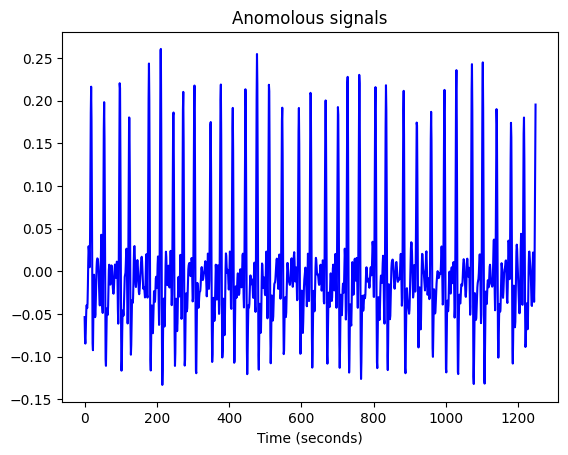

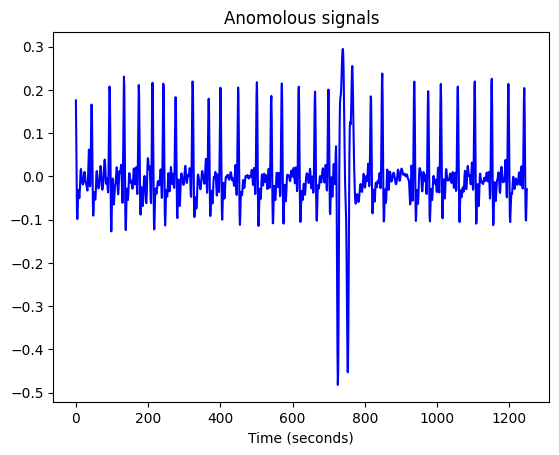

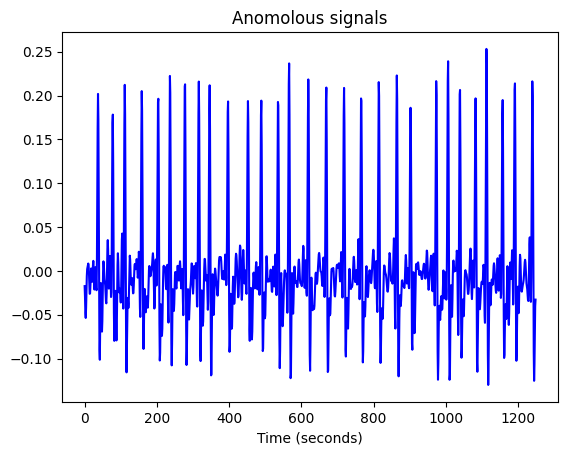

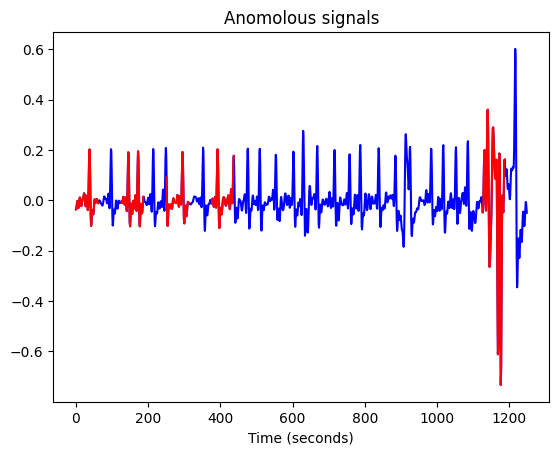

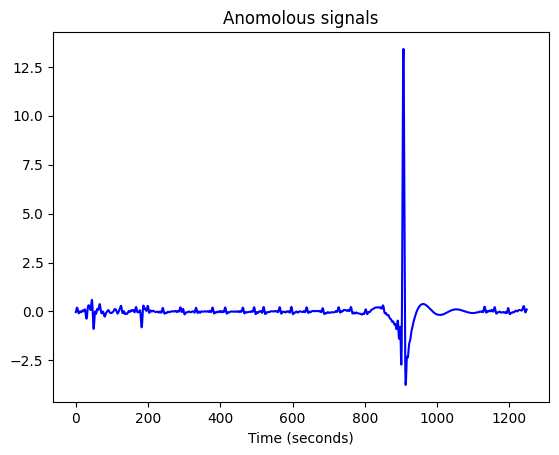

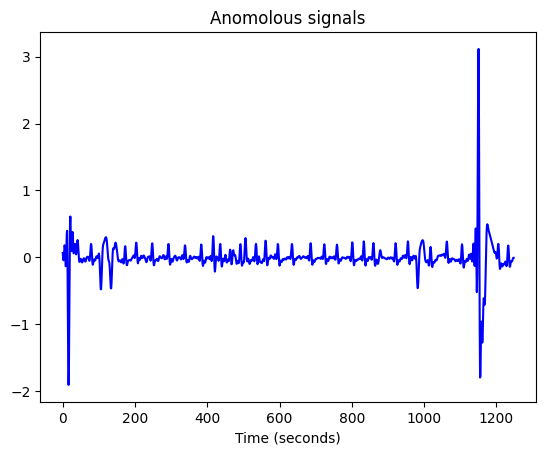

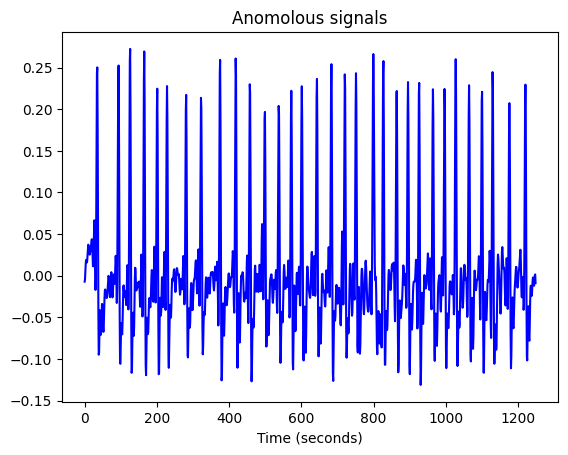

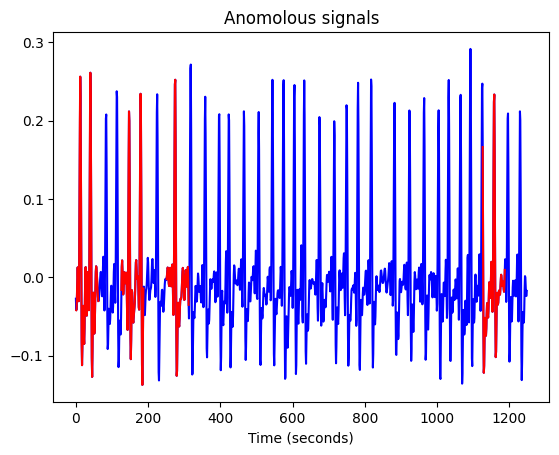

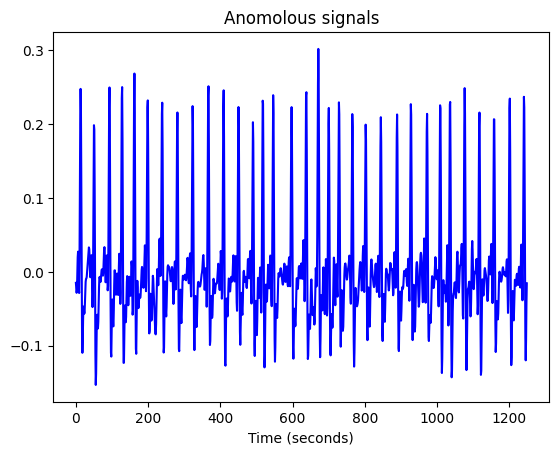

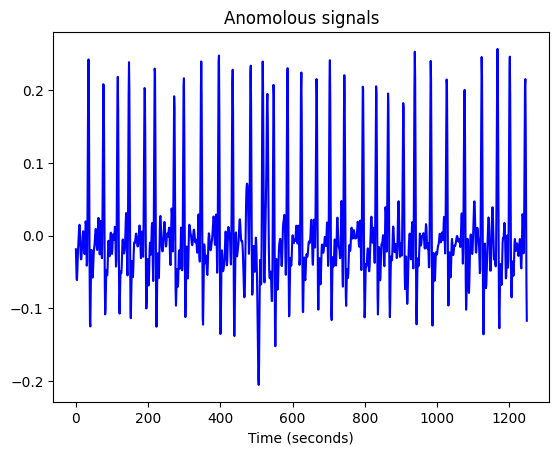

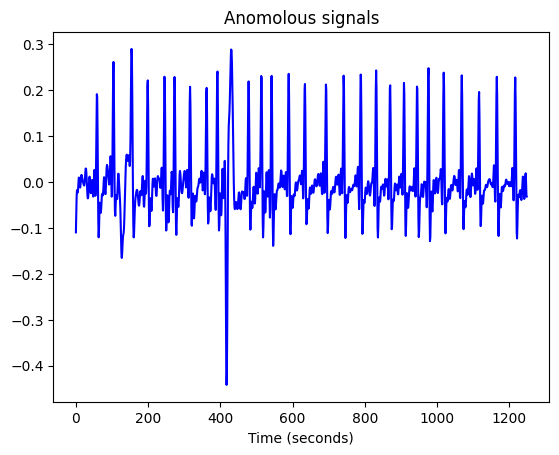

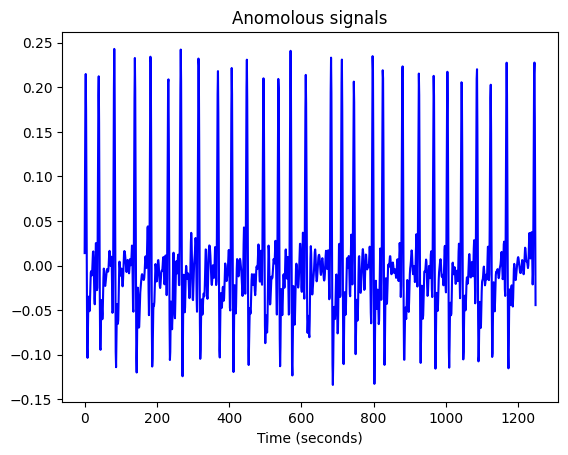

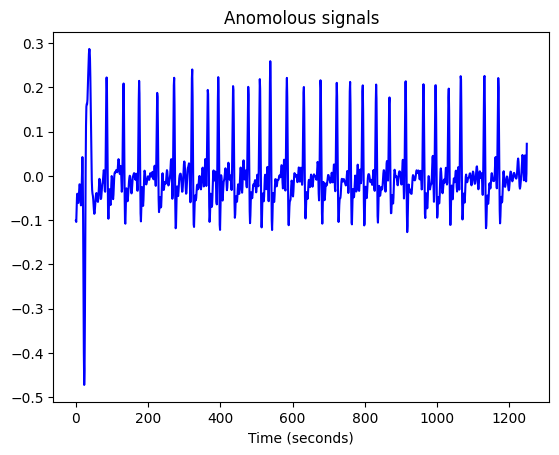

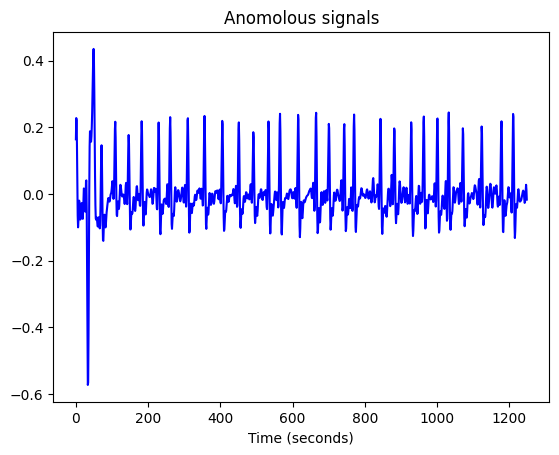

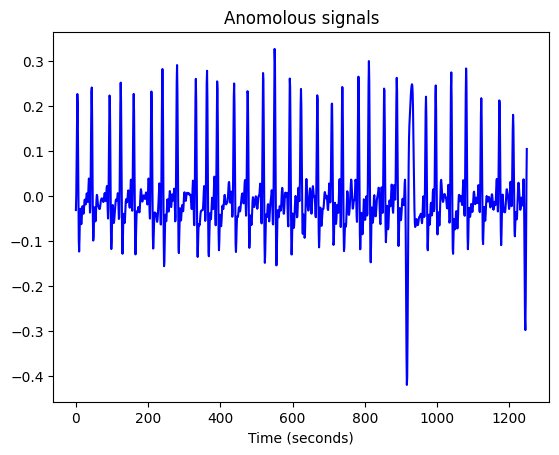

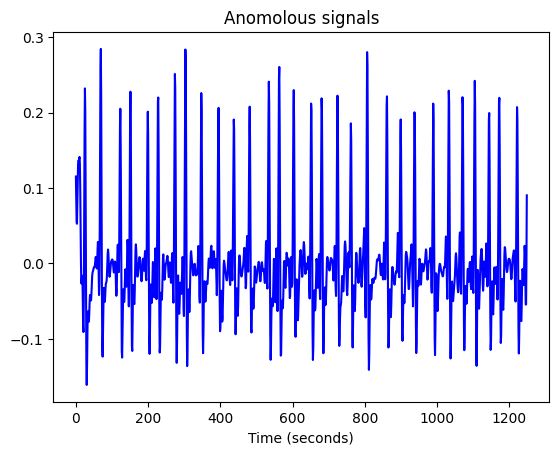

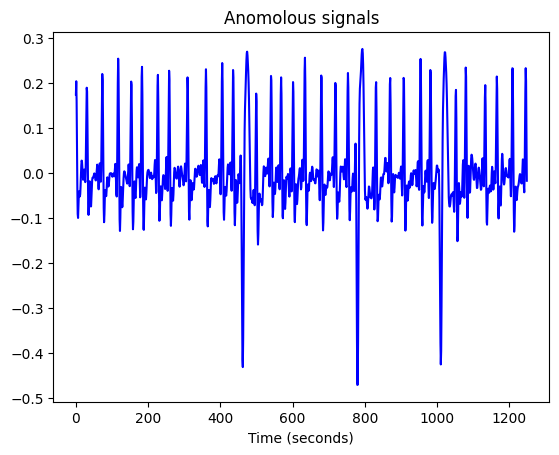

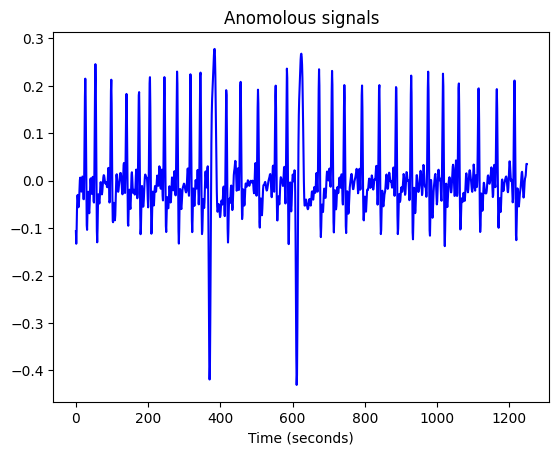

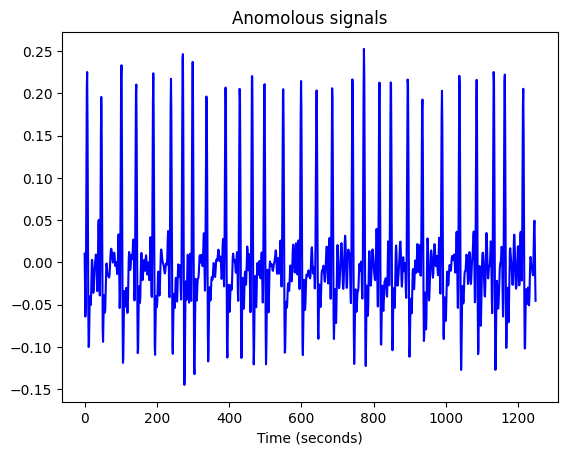

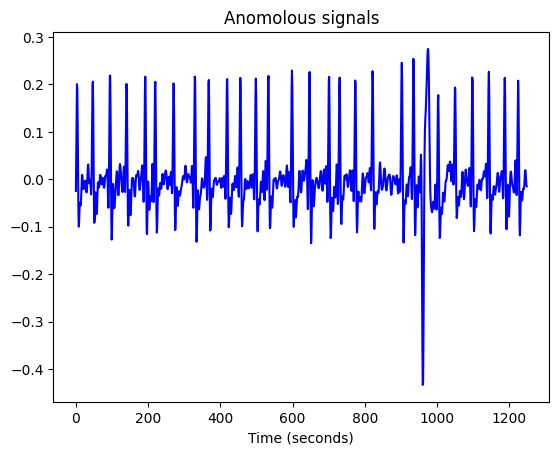

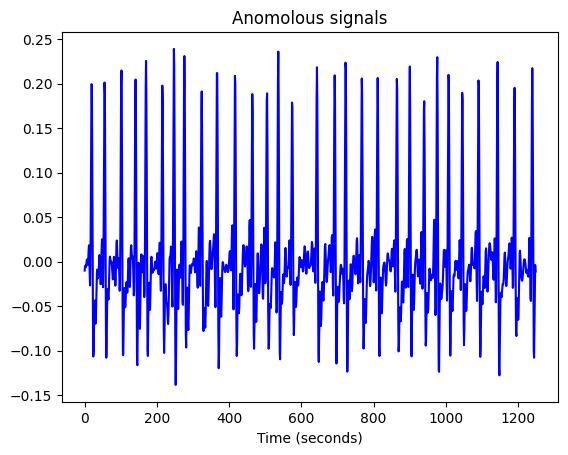

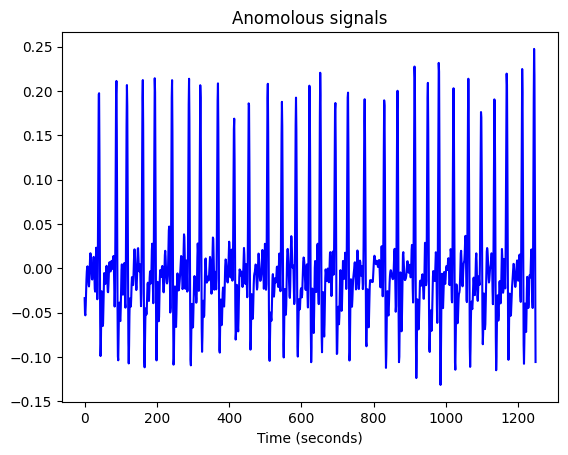

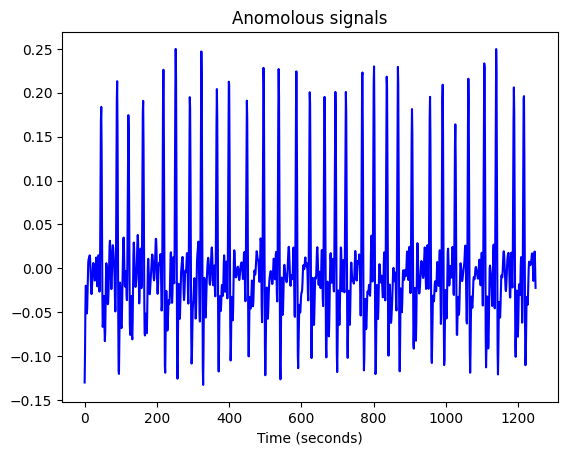

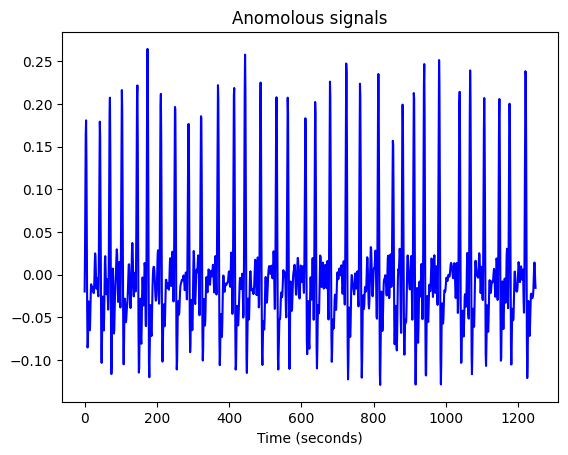

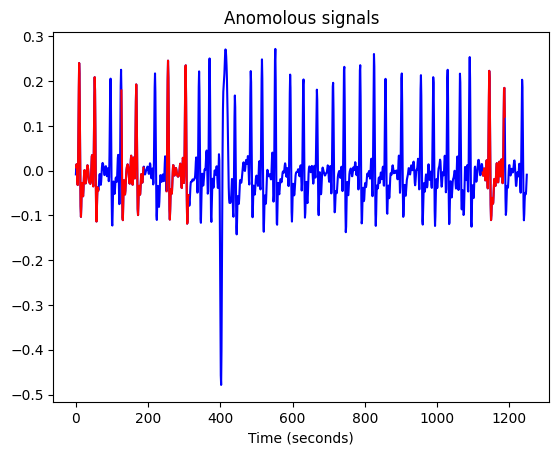

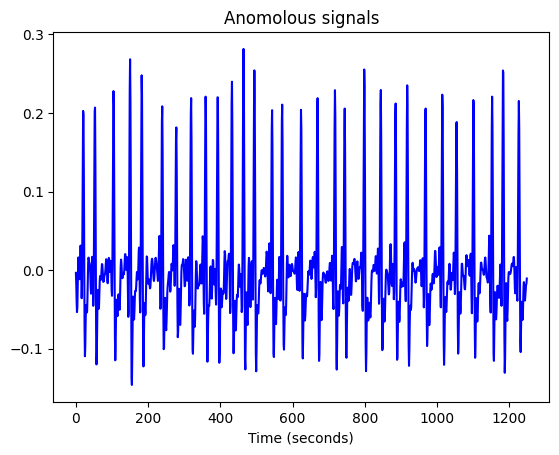

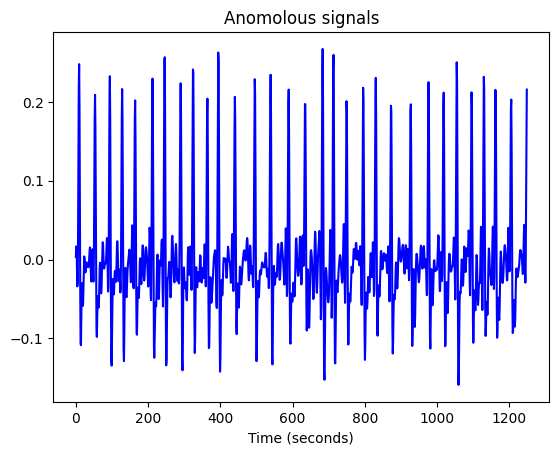

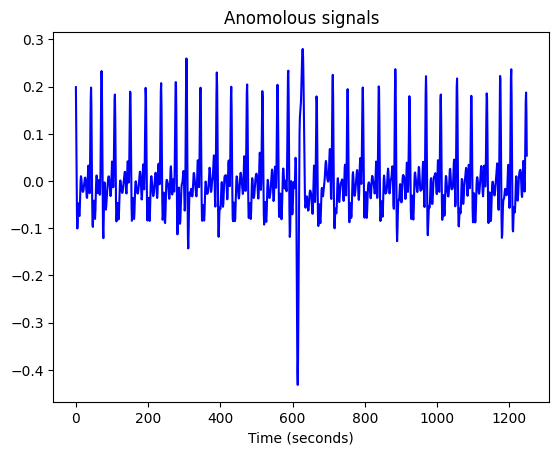

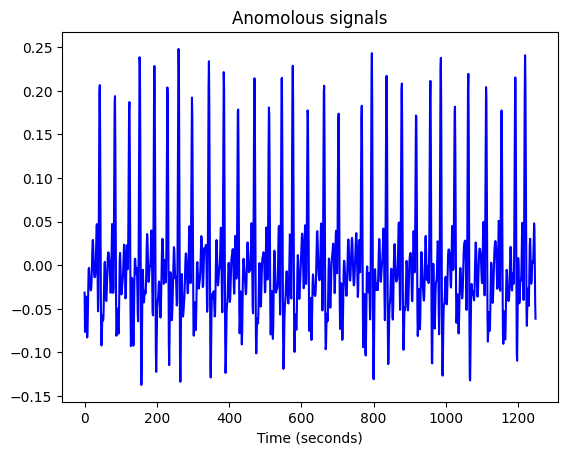

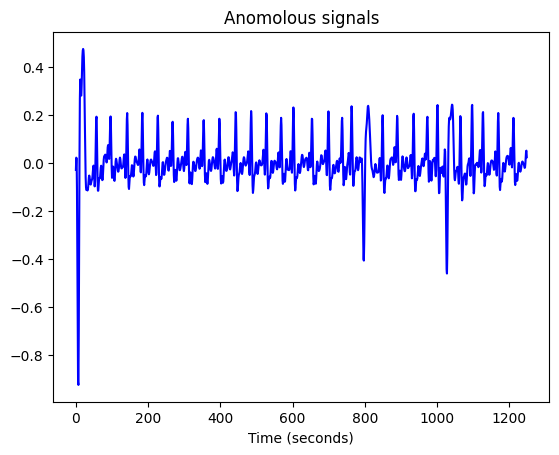

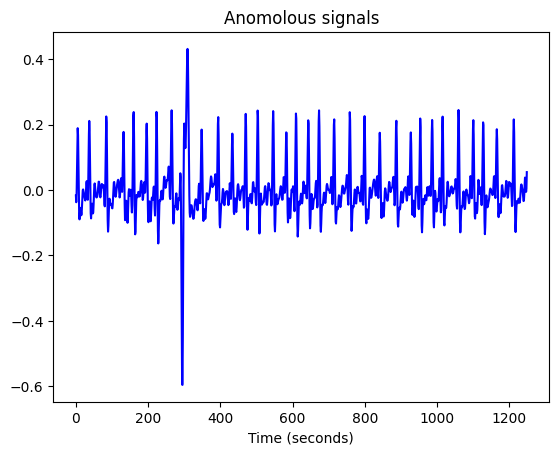

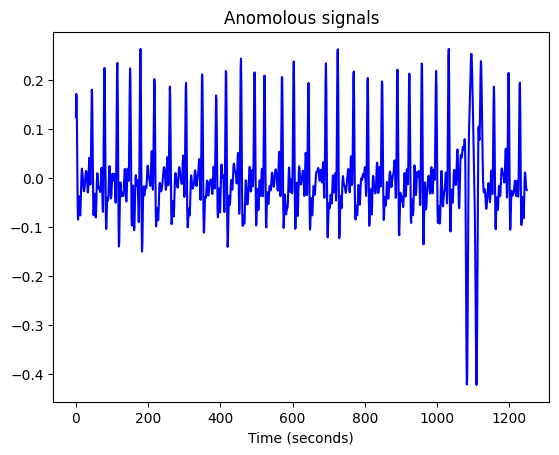

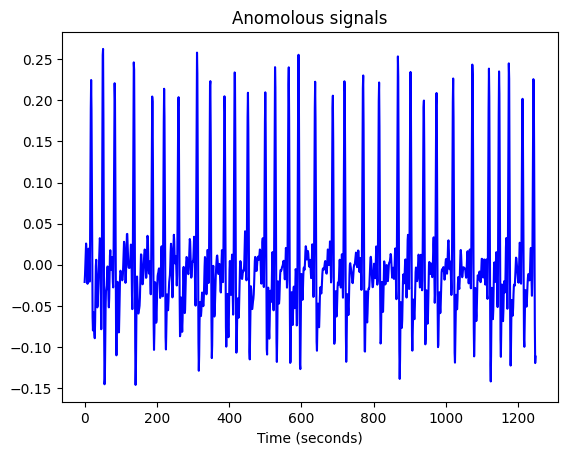

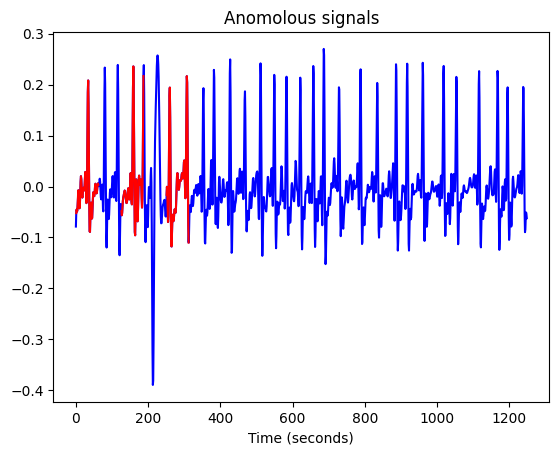

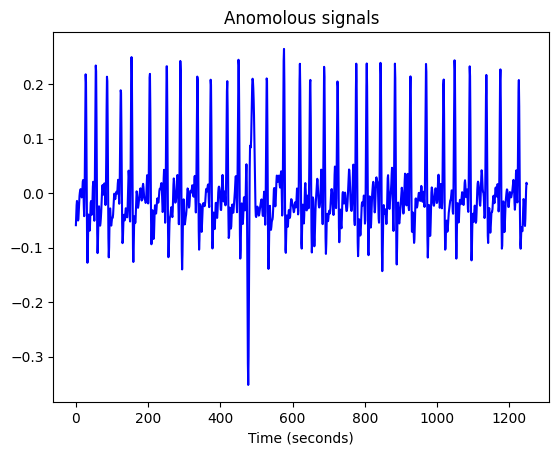

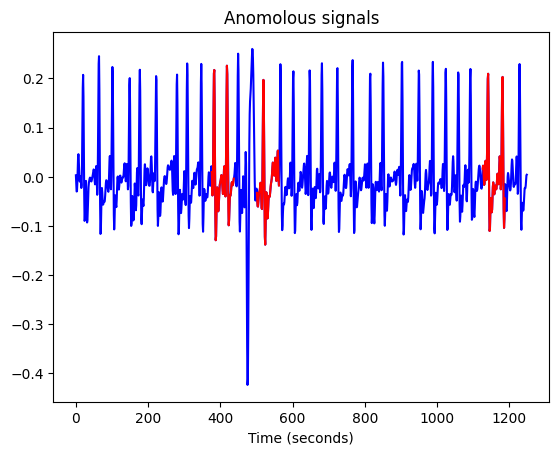

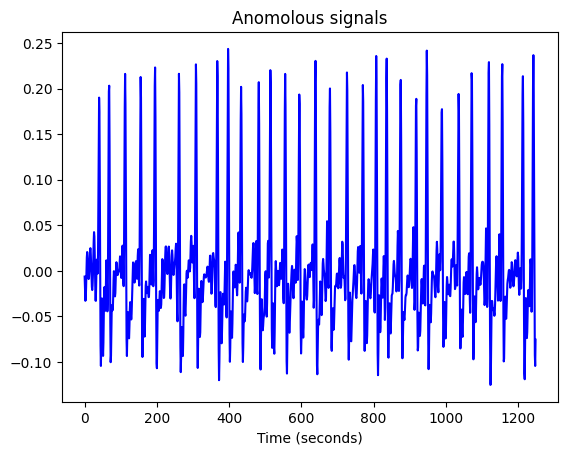

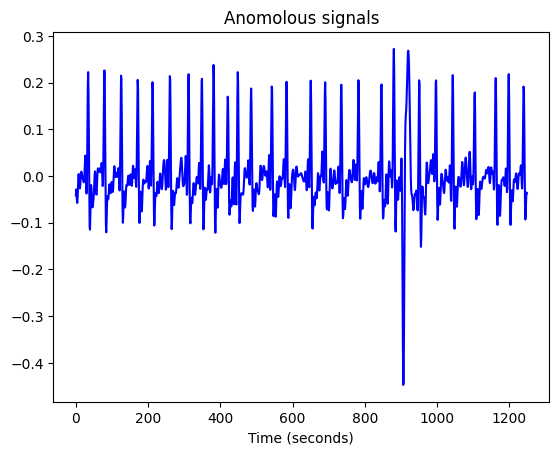

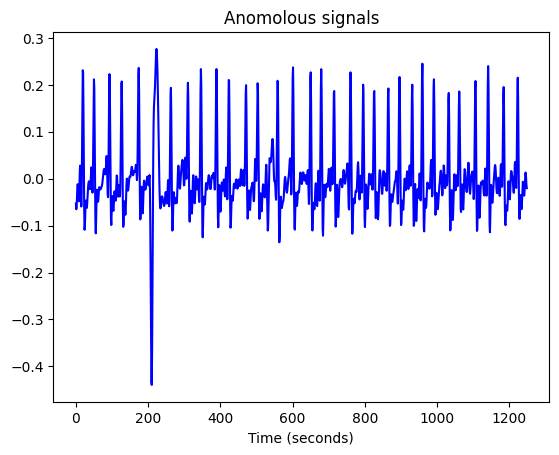

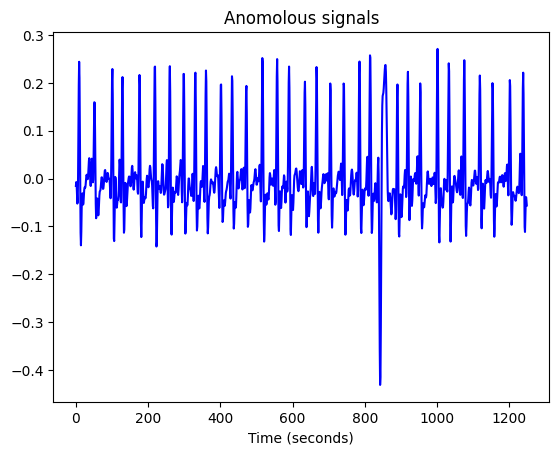

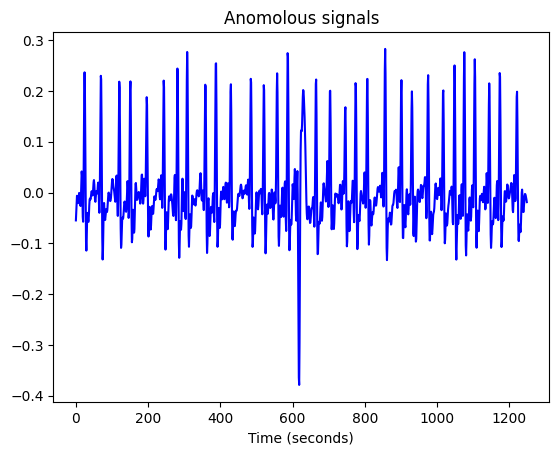

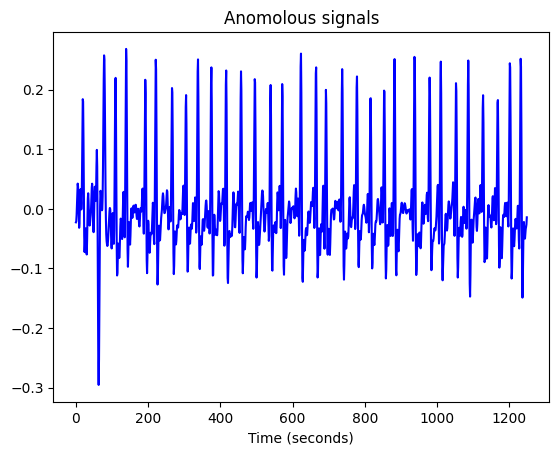

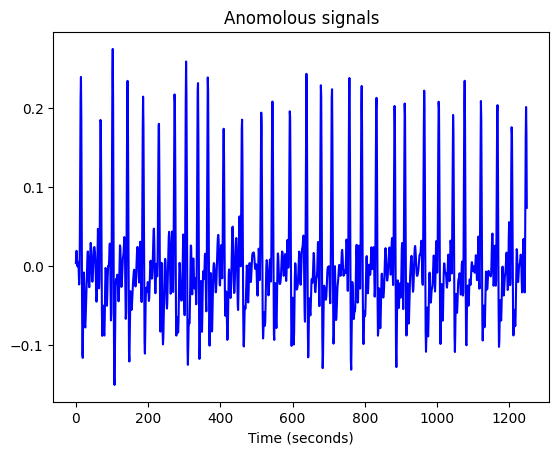

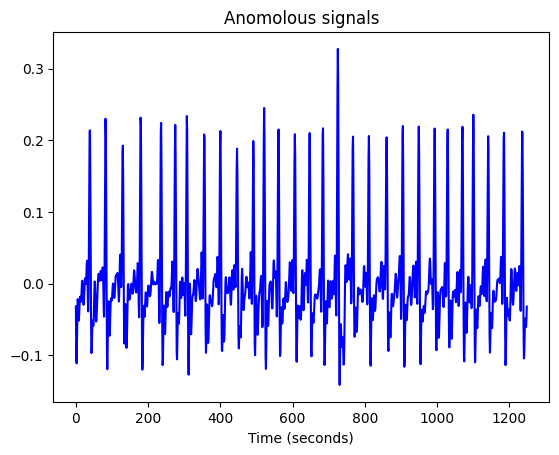

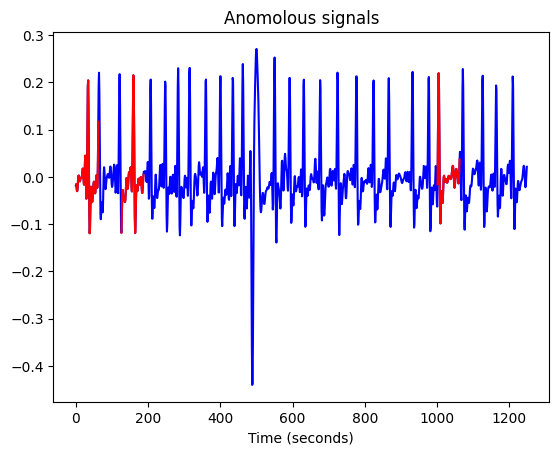

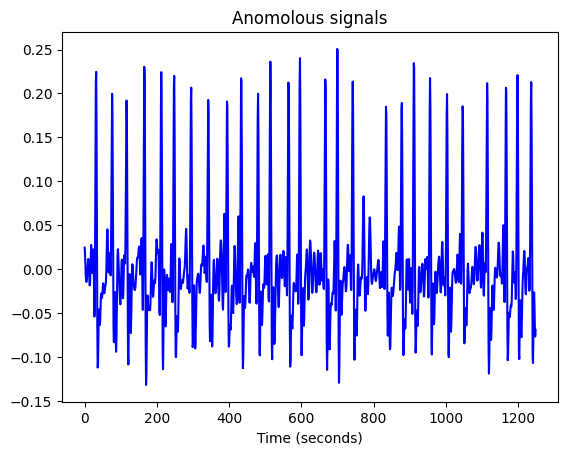

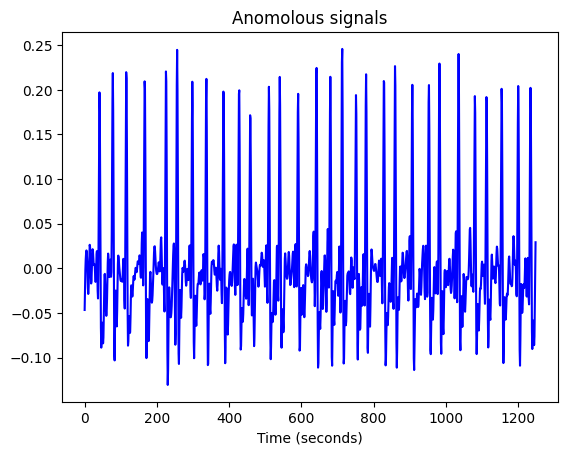

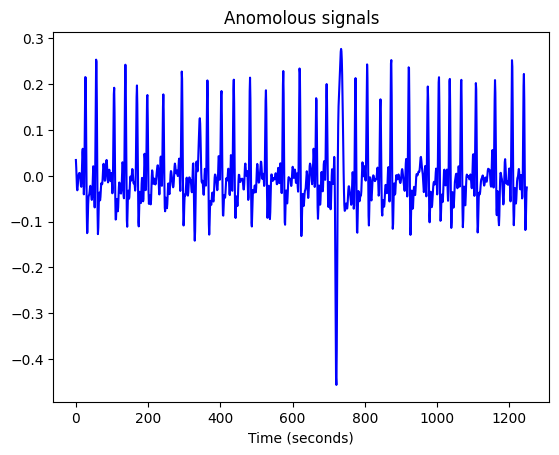

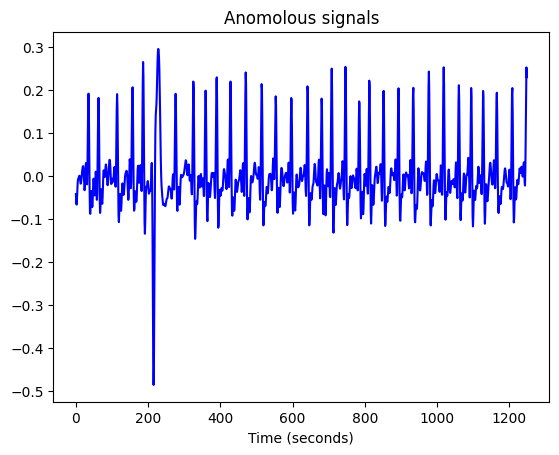

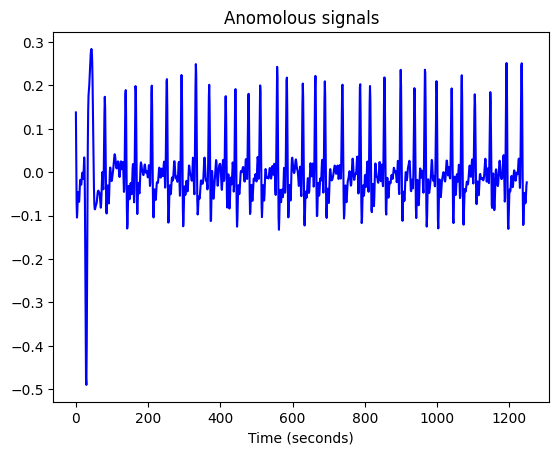

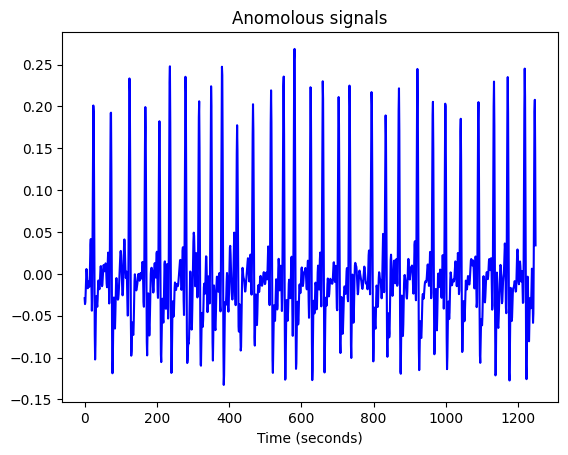

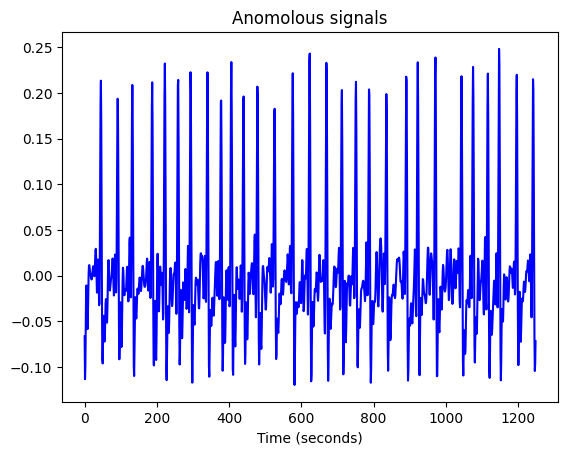

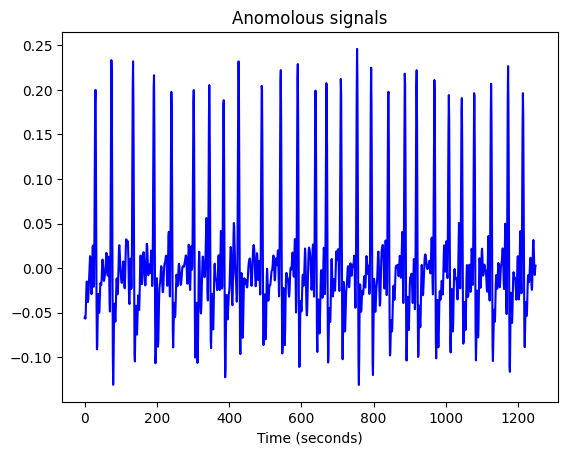

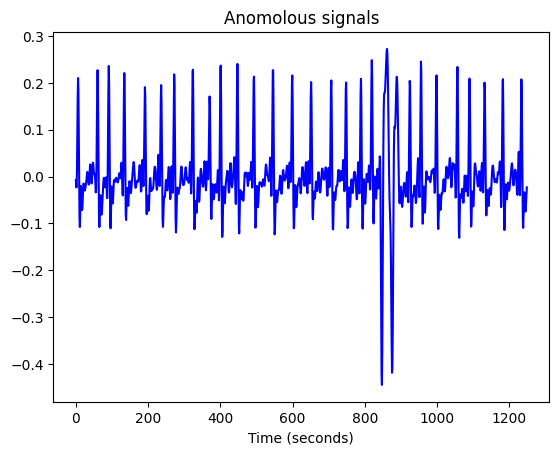

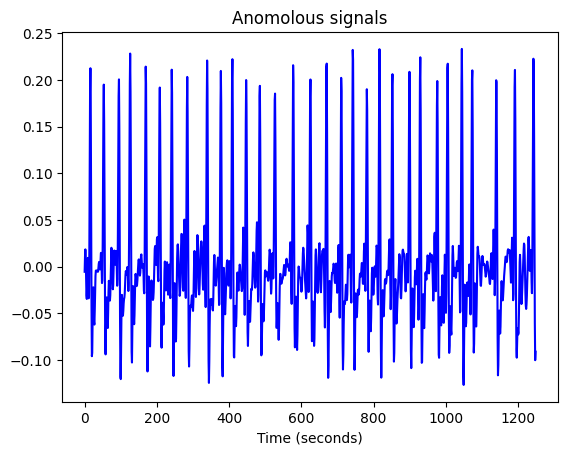

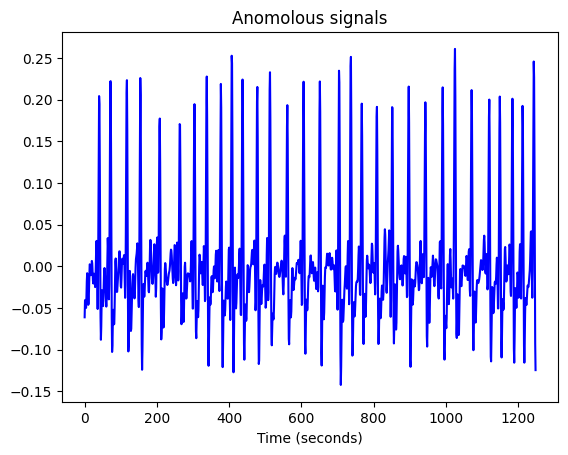

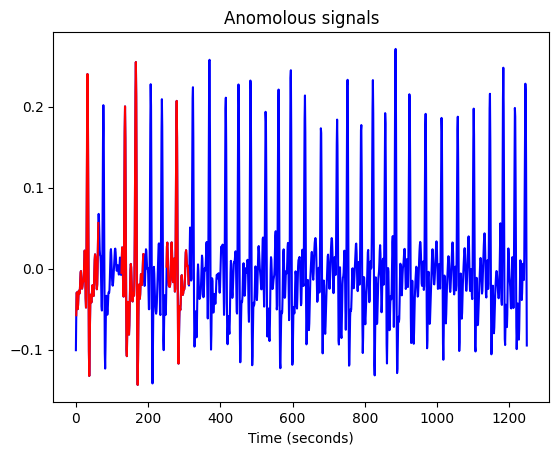

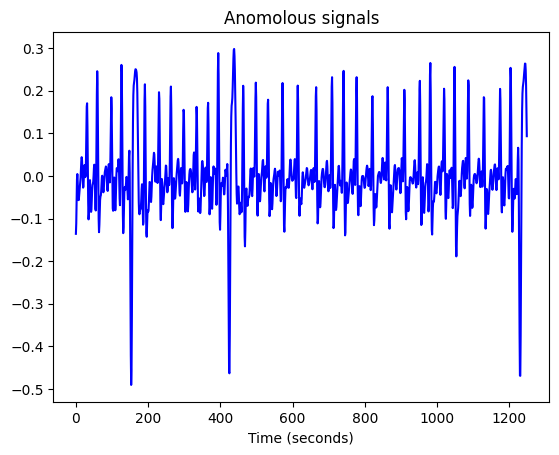

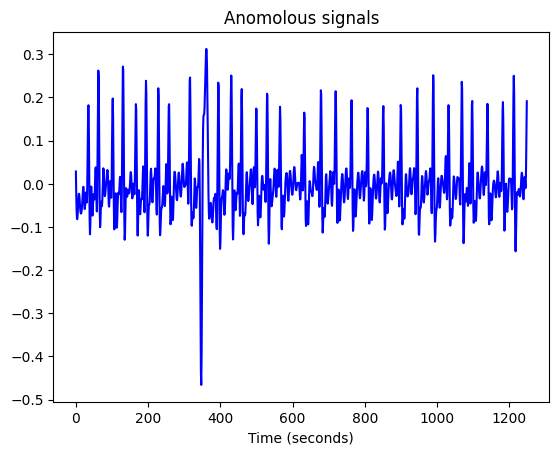

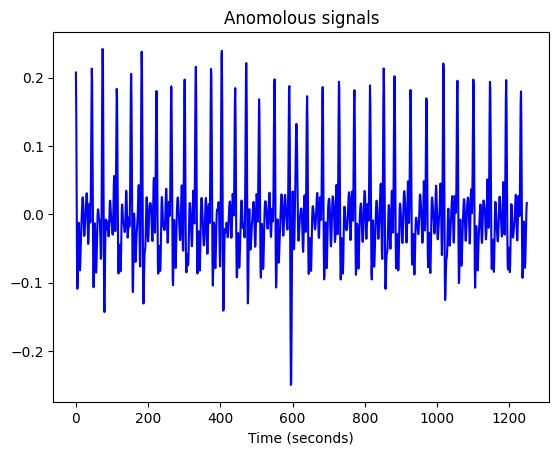

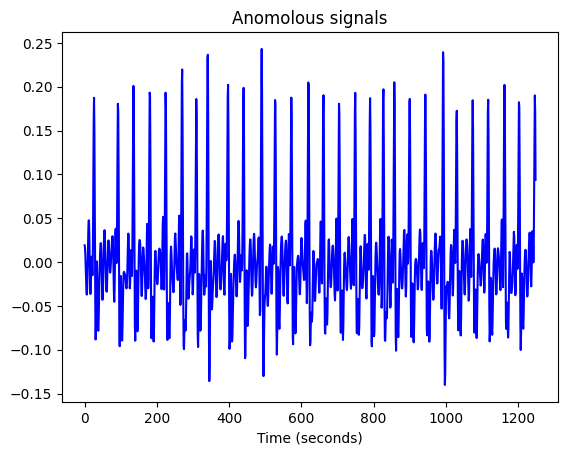

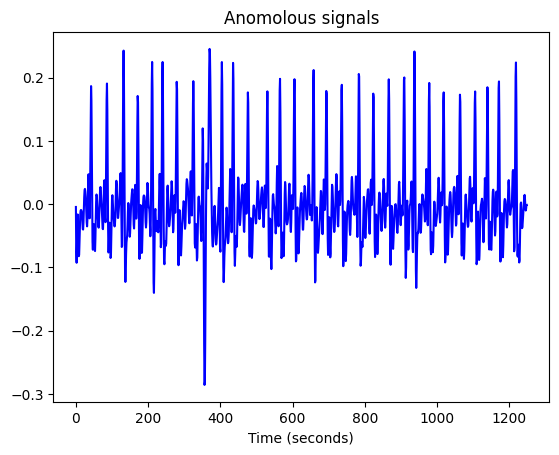

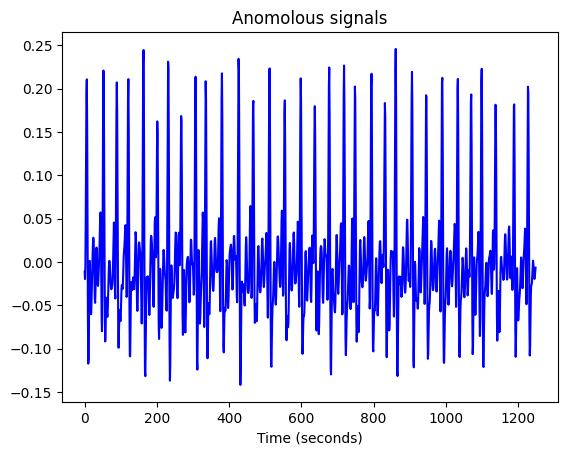

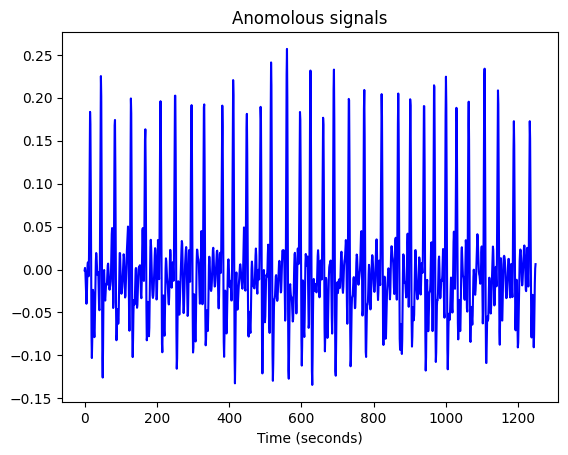

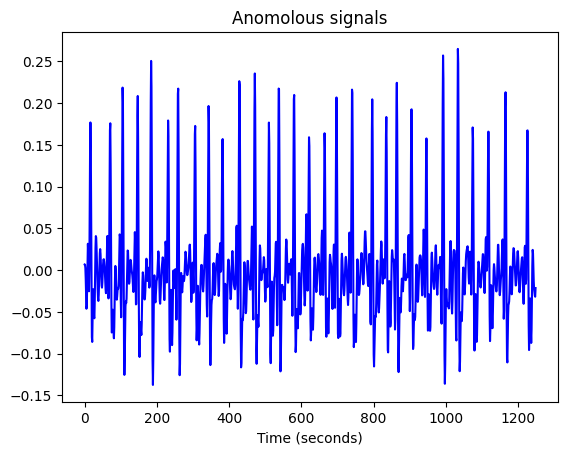

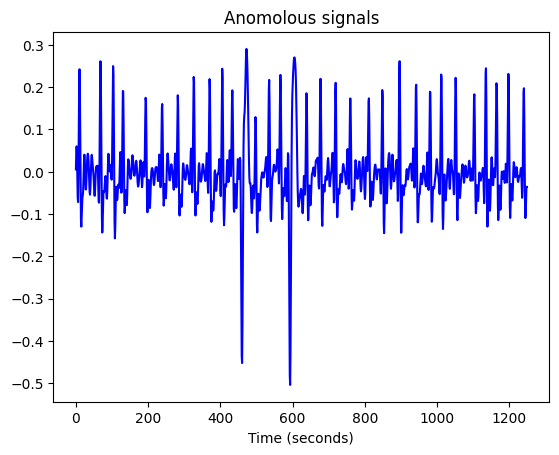

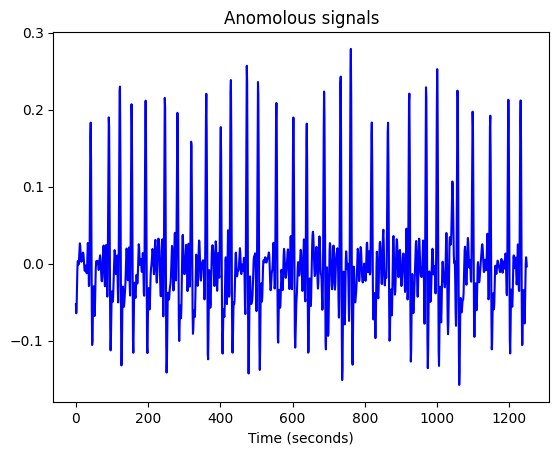

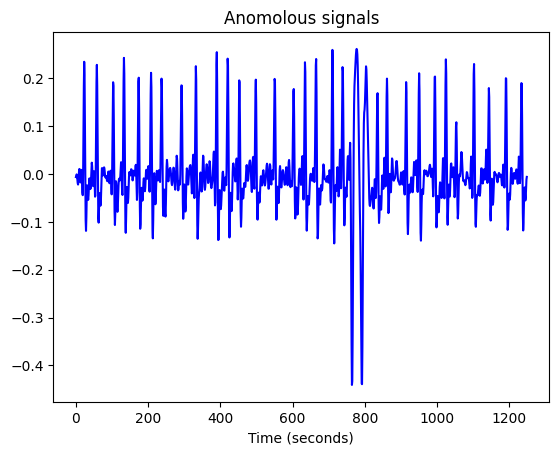

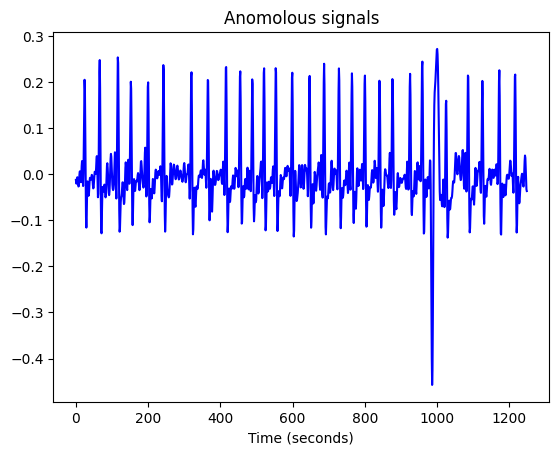

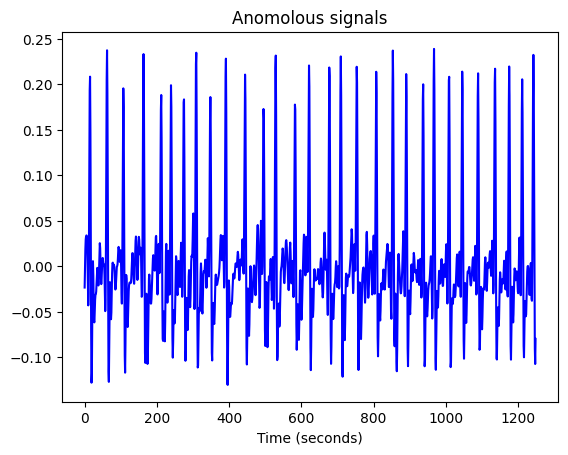

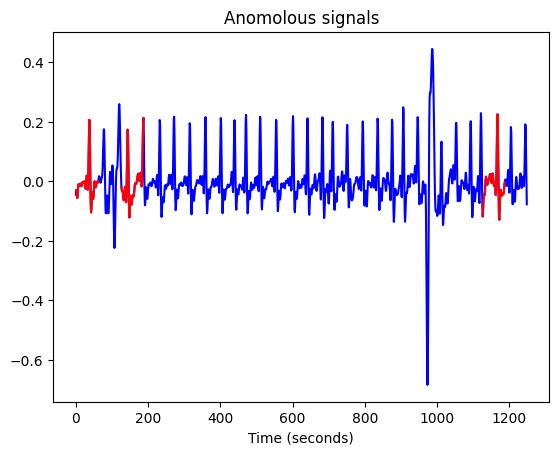

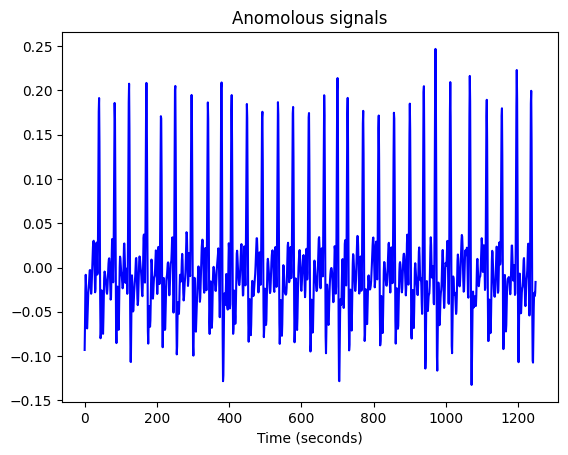

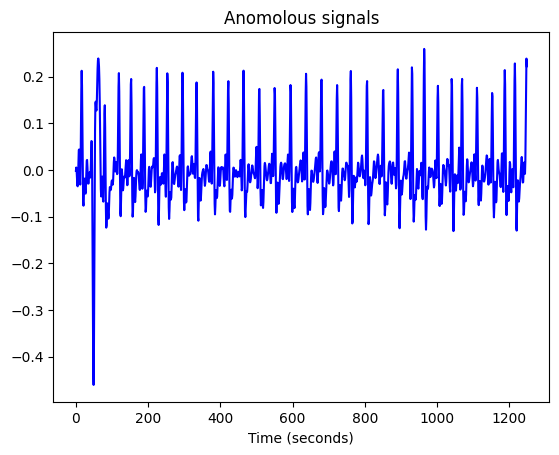

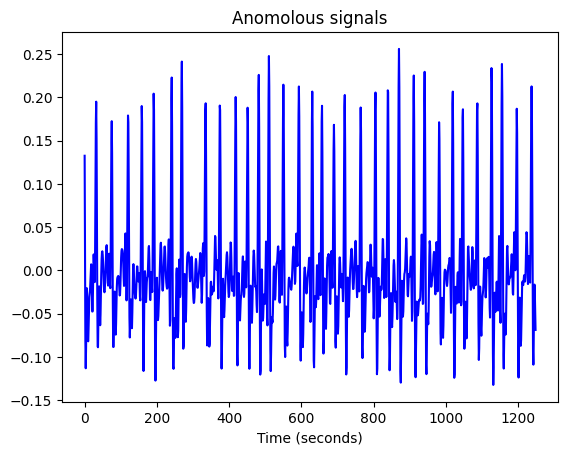

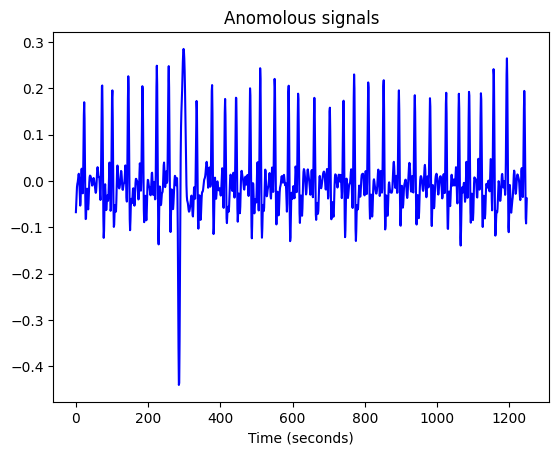

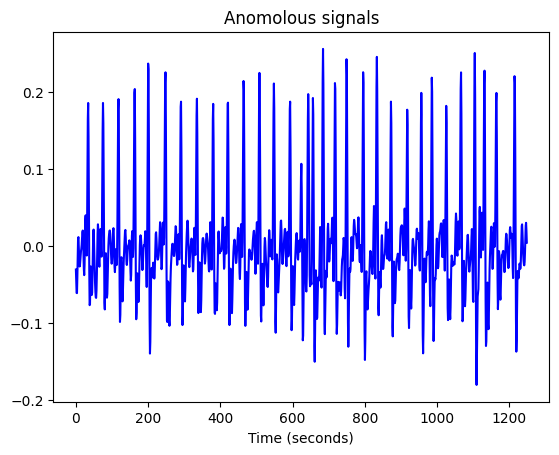

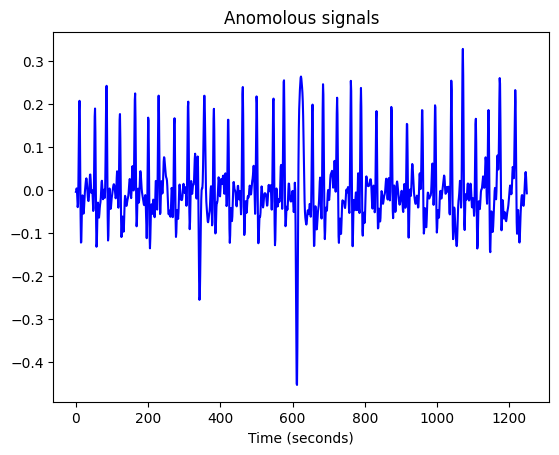

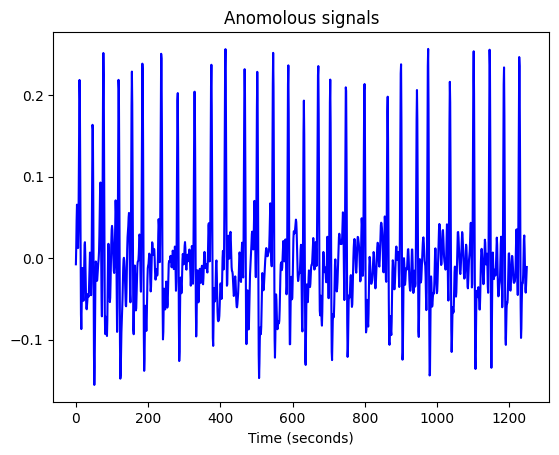

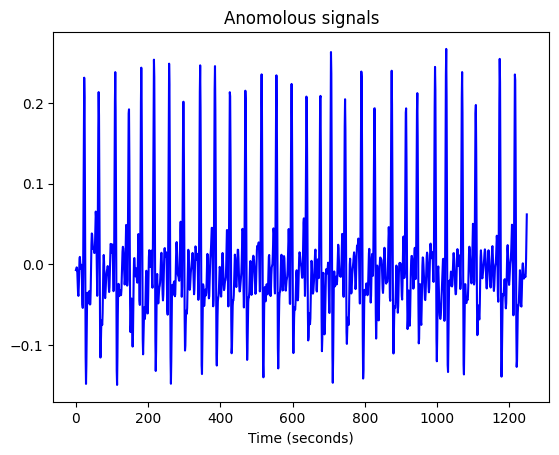

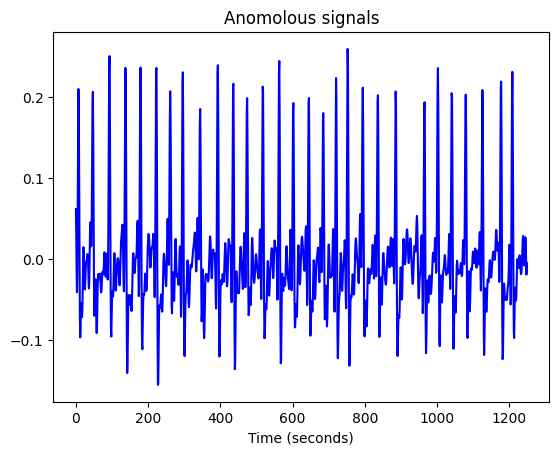

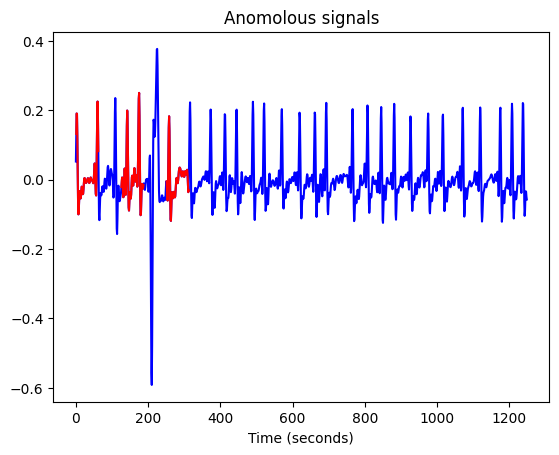

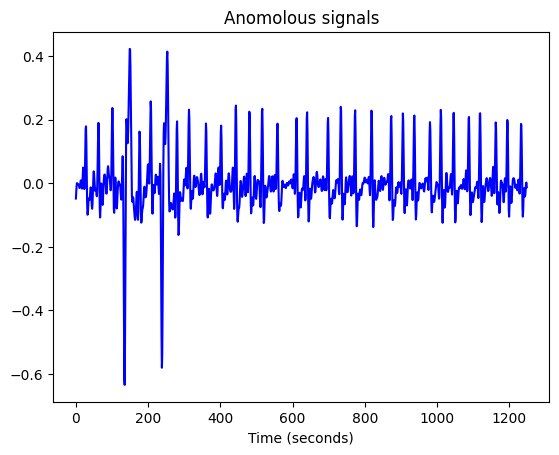

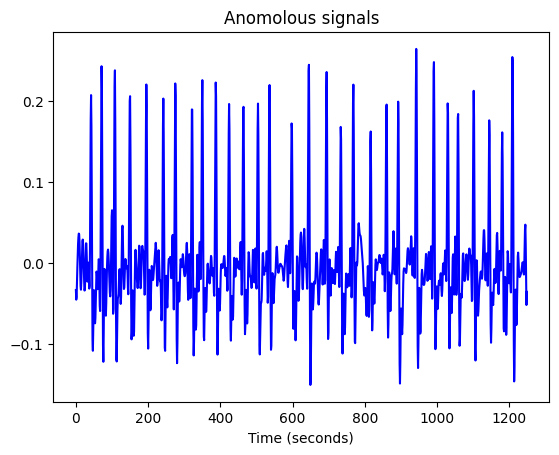

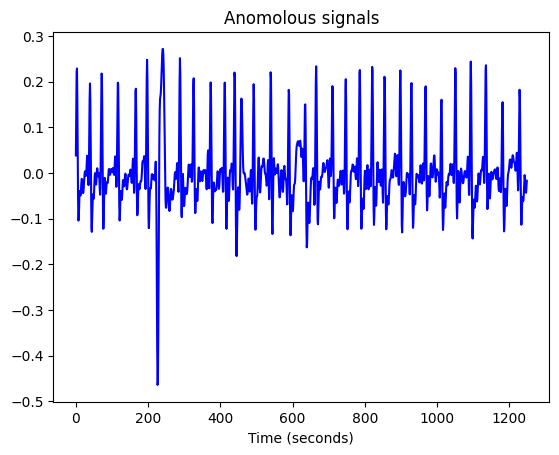

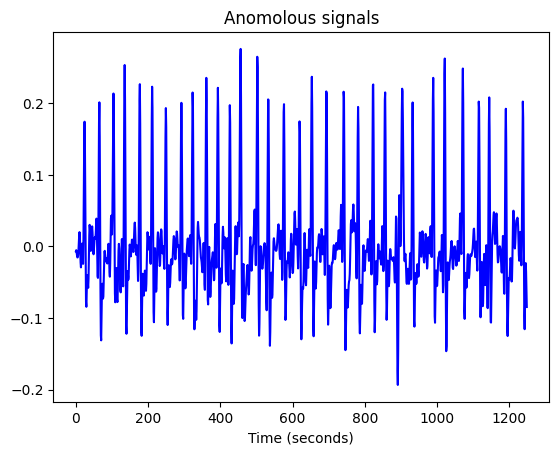

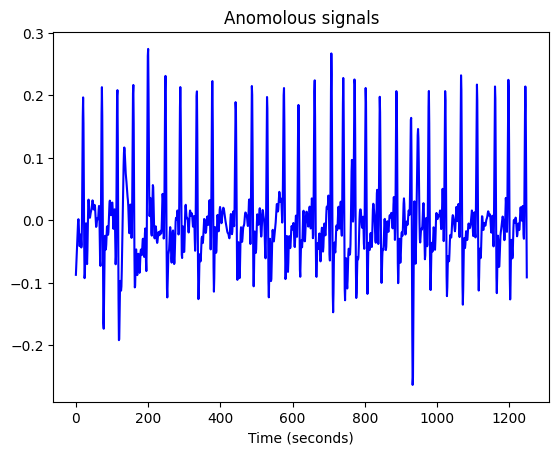

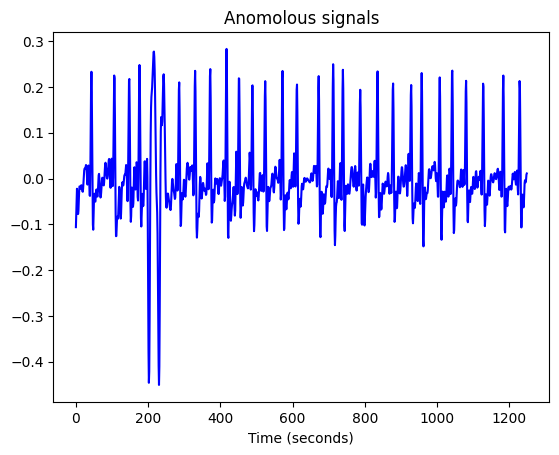

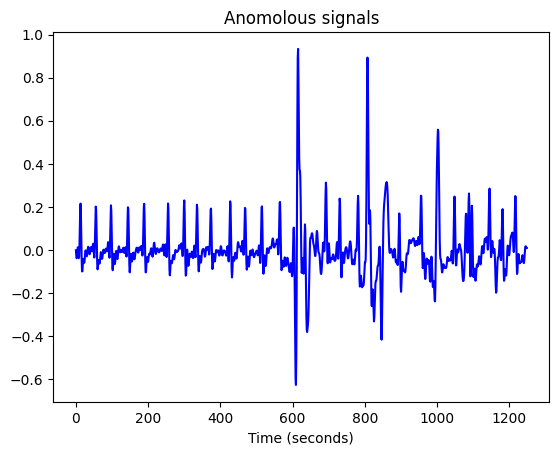

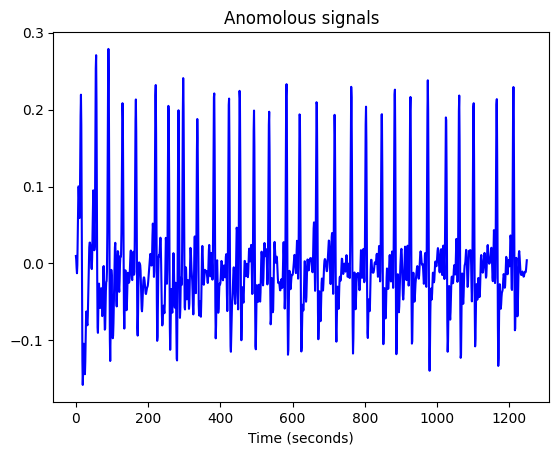

In [24]:
for i in range(100):
    find_anomalies_using_DBSCAN(segments_ecg[i], i)